<a href="https://colab.research.google.com/github/priyankabutun/Data/blob/main/Myocd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
#importing required packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
warnings.filterwarnings("ignore")
%matplotlib inline
sns.set(style="whitegrid")
import missingno as msno
#Interactive
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
from IPython.display import clear_output



In [56]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import optuna
import xgboost as xgb
from xgboost import XGBClassifier
import catboost
from catboost import CatBoostClassifier
import lightgbm as lgbm
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin,ClassifierMixin, clone
from sklearn.model_selection import KFold
from scipy import stats
from scipy.stats import norm, skew
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn import datasets
optuna.logging.set_verbosity(optuna.logging.WARNING)
from lightgbm import *
pd.set_option("display.max_columns", None)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import eli5
from eli5.sklearn import PermutationImportance

In [57]:
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 $('div.cell.code_cell.rendered.selected div.output').hide(); // Hide output of selected cell as well
 } else {
 $('div.input').show();
 $('div.cell.code_cell.rendered.selected div.output').show(); // Show output of selected cell as well
 }
 code_show = !code_show
 $('div.cell.code_cell.rendered.selected div.input').hide();
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" class="btn btn-primary" value="Click here to toggle on/off the raw code."></form>''')

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
file_path = '/content/drive/MyDrive/Colab Notebooks/ocd.csv'
df= pd.read_csv(file_path)

In [14]:
display(df.head())

,Patient ID,Age,Gender,Ethnicity,Marital Status,Education Level,OCD Diagnosis Date,Duration of Symptoms (months),Previous Diagnoses,Family History of OCD,Obsession Type,Compulsion Type,Y-BOCS Score (Obsessions),Y-BOCS Score (Compulsions),Depression Diagnosis,Anxiety Diagnosis,Medications
0,1018,32,Female,African,Single,Some College,2016-07-15,203,MDD,No,Harm-related,Checking,17,10,Yes,Yes,SNRI
1,2406,69,Male,African,Divorced,Some College,2017-04-28,180,NaN,Yes,Harm-related,Washing,21,25,Yes,Yes,SSRI
2,1188,57,Male,Hispanic,Divorced,College Degree,2018-02-02,173,MDD,No,Contamination,Checking,3,4,No,No,Benzodiazepine
3,6200,27,Female,Hispanic,Married,College Degree,2014-08-25,126,PTSD,Yes,Symmetry,Washing,14,28,Yes,Yes,SSRI
4,5824,56,Female,Hispanic,Married,High School,2022-02-20,168,PTSD,Yes,Hoarding,Ordering,39,18,No,No,NaN


In [15]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Check for duplicate rows
print("\nNumber of duplicate rows:")
print(df.duplicated().sum())

Missing values per column:
Patient ID                         0
Age                                0
Gender                             0
Ethnicity                          0
Marital Status                     0
Education Level                    0
OCD Diagnosis Date                 0
Duration of Symptoms (months)      0
Previous Diagnoses               248
Family History of OCD              0
Obsession Type                     0
Compulsion Type                    0
Y-BOCS Score (Obsessions)          0
Y-BOCS Score (Compulsions)         0
Depression Diagnosis               0
Anxiety Diagnosis                  0
Medications                      386
dtype: int64

Number of duplicate rows:
0


In [16]:
df.replace('Unknown', np.nan, inplace=True)

In [17]:

# Extract age and duration data
age_data = df['Age'].values
duration_data = df['Duration of Symptoms (months)'].values

print(f"Age range: {age_data.min()} to {age_data.max()} years")
print(f"Duration range: {duration_data.min()} to {duration_data.max()} months")
print(f"Total patients: {len(age_data)}")

Age range: 18 to 75 years
Duration range: 6 to 240 months
Total patients: 1500


In [18]:
# Create age groups
df['Age_Group'] = pd.cut(df['Age'],
                        bins=[17, 25, 35, 45, 55, 65, 76],
                        labels=['18-25', '26-35', '36-45', '46-55', '56-65', '66-75'])

# Calculate average duration for each age group
age_duration_stats = df.groupby('Age_Group', observed=True)['Duration of Symptoms (months)'].agg([
    'mean', 'count', 'std'
]).round(1)

age_duration_stats.columns = ['Avg_Duration', 'Patient_Count', 'Std_Dev']
age_duration_stats = age_duration_stats.reset_index()

print("Age Group Analysis:")
for i, row in age_duration_stats.iterrows():
    print(f"{row['Age_Group']}: {row['Avg_Duration']} months (n={row['Patient_Count']}, std={row['Std_Dev']})")

Age Group Analysis:
18-25: 120.4 months (n=191, std=68.1)
26-35: 128.0 months (n=272, std=67.8)
36-45: 120.6 months (n=248, std=71.4)
46-55: 117.4 months (n=270, std=66.1)
56-65: 116.7 months (n=241, std=65.1)
66-75: 126.3 months (n=278, std=65.9)


In [19]:
# Statistical analysis of Gender and Obsession Type
print("Statistical Analysis of Gender and Obsession Type:")
gender_obsession_counts = pd.crosstab(df['Gender'], df['Obsession Type'])
display(gender_obsession_counts)

print("\nStatistical Analysis of Gender and Compulsion Type:")
# Statistical analysis of Gender and Compulsion Type
gender_compulsion_counts = pd.crosstab(df['Gender'], df['Compulsion Type'])
display(gender_compulsion_counts)

Statistical Analysis of Gender and Obsession Type:


Obsession Type,Contamination,Harm-related,Hoarding,Religious,Symmetry
Gender,,,,,
Female,147,169,144,149,138
Male,159,164,134,154,142



Statistical Analysis of Gender and Compulsion Type:


Compulsion Type,Checking,Counting,Ordering,Praying,Washing
Gender,,,,,
Female,151,140,146,149,161
Male,141,176,139,137,160


In [20]:
# Get value counts for 'Previous Diagnoses', including missing values
previous_diagnosis_counts = df['Previous Diagnoses'].value_counts(dropna=False)

# Calculate percentages, including missing values
previous_diagnosis_percentages = df['Previous Diagnoses'].value_counts(dropna=False, normalize=True) * 100

# Combine counts and percentages into a DataFrame for display
previous_diagnosis_analysis = pd.DataFrame({
    'Count': previous_diagnosis_counts,
    'Percentage': previous_diagnosis_percentages.round(1)
})

print("Statistical Analysis of Previous Diagnoses:")
display(previous_diagnosis_analysis)

Statistical Analysis of Previous Diagnoses:


,Count,Percentage
Previous Diagnoses,,
MDD,345,23.0
Panic Disorder,313,20.9
GAD,298,19.9
PTSD,296,19.7
NaN,248,16.5


In [21]:
# Convert numerical columns to proper data types
df['Age'] = pd.to_numeric(df['Age'])
df['Duration of Symptoms (months)'] = pd.to_numeric(df['Duration of Symptoms (months)'])
df['Y-BOCS Score (Obsessions)'] = pd.to_numeric(df['Y-BOCS Score (Obsessions)'])
df['Y-BOCS Score (Compulsions)'] = pd.to_numeric(df['Y-BOCS Score (Compulsions)'])
# Calculate total Y-BOCS score
df['Total_YBOCS'] = df['Y-BOCS Score (Obsessions)'] + df['Y-BOCS Score (Compulsions)']

# Create comprehensive statistical summary
summary_data = []

# Dataset Overview
summary_data.append(['DATASET OVERVIEW', ''])
summary_data.append(['Total Patients', str(len(df))])
summary_data.append(['Total Variables', str(len(df.columns))])
summary_data.append(['', ''])

# Age Statistics
age_stats = df['Age'].describe()
summary_data.append(['AGE DISTRIBUTION', ''])
summary_data.append(['Mean Age', f"{age_stats['mean']:.1f} years"])
summary_data.append(['Median Age', f"{age_stats['50%']:.1f} years"])
summary_data.append(['Age Range', f"{age_stats['min']:.0f} - {age_stats['max']:.0f} years"])
summary_data.append(['Standard Deviation', f"{age_stats['std']:.1f} years"])
summary_data.append(['', ''])

# Gender Distribution
summary_data.append(['GENDER DISTRIBUTION', ''])
gender_counts = df['Gender'].value_counts()
gender_pct = df['Gender'].value_counts(normalize=True) * 100
for gender in gender_counts.index:
    summary_data.append([f'{gender}', f"{gender_counts[gender]} ({gender_pct[gender]:.1f}%)"])
summary_data.append(['', ''])

# Duration of Symptoms
duration_stats = df['Duration of Symptoms (months)'].describe()
summary_data.append(['SYMPTOM DURATION (MONTHS)', ''])
summary_data.append(['Mean Duration', f"{duration_stats['mean']:.1f} months"])
summary_data.append(['Median Duration', f"{duration_stats['50%']:.1f} months"])
summary_data.append(['Range', f"{duration_stats['min']:.0f} - {duration_stats['max']:.0f} months"])
summary_data.append(['', ''])

# Y-BOCS Scores
ob_stats = df['Y-BOCS Score (Obsessions)'].describe()
comp_stats = df['Y-BOCS Score (Compulsions)'].describe()
total_stats = df['Total_YBOCS'].describe()

summary_data.append(['Y-BOCS SCORES', ''])
summary_data.append(['Obsessions - Mean', f"{ob_stats['mean']:.1f}"])
summary_data.append(['Obsessions - Range', f"{ob_stats['min']:.0f} - {ob_stats['max']:.0f}"])
summary_data.append(['Compulsions - Mean', f"{comp_stats['mean']:.1f}"])
summary_data.append(['Compulsions - Range', f"{comp_stats['min']:.0f} - {comp_stats['max']:.0f}"])
summary_data.append(['Total Score - Mean', f"{total_stats['mean']:.1f}"])
summary_data.append(['Total Score - Range', f"{total_stats['min']:.0f} - {total_stats['max']:.0f}"])
summary_data.append(['', ''])

# Comorbidities
depression_pct = (df['Depression Diagnosis'] == 'Yes').sum() / len(df) * 100
anxiety_pct = (df['Anxiety Diagnosis'] == 'Yes').sum() / len(df) * 100
both_conditions = ((df['Depression Diagnosis'] == 'Yes') & (df['Anxiety Diagnosis'] == 'Yes')).sum() / len(df) * 100

summary_data.append(['COMORBIDITIES', ''])
summary_data.append(['Depression Diagnosis', f"{depression_pct:.1f}%"])
summary_data.append(['Anxiety Diagnosis', f"{anxiety_pct:.1f}%"])
summary_data.append(['Both Conditions', f"{both_conditions:.1f}%"])
summary_data.append(['', ''])

# Family History
family_history_pct = (df['Family History of OCD'] == 'Yes').sum() / len(df) * 100
summary_data.append(['FAMILY HISTORY', ''])
summary_data.append(['Family History of OCD', f"{family_history_pct:.1f}%"])

# Create DataFrame for display
summary_df = pd.DataFrame(summary_data, columns=['Statistic', 'Value'])
summary_df

,Statistic,Value
0,DATASET OVERVIEW,
1,Total Patients,1500
2,Total Variables,19
3,,
4,AGE DISTRIBUTION,
5,Mean Age,46.8 years
6,Median Age,47.0 years
7,Age Range,18 - 75 years
8,Standard Deviation,16.8 years
9,,


In [22]:
# Calculate statistical summary of 'Duration of Symptoms (months)' by 'Education Level'
education_duration_stats = df.groupby('Education Level', observed=True)['Duration of Symptoms (months)'].agg(['mean', 'count', 'std']).round(1)

education_duration_stats.columns = ['Avg_Duration', 'Patient_Count', 'Std_Dev']

print("Statistical Analysis of Duration of Symptoms by Education Level:")
print(education_duration_stats)

Statistical Analysis of Duration of Symptoms by Education Level:
                 Avg_Duration  Patient_Count  Std_Dev
Education Level                                      
College Degree          125.0            366     68.9
Graduate Degree         118.5            376     68.9
High School             121.1            364     64.2
Some College            122.4            394     67.6


In [23]:
# Calculate the average Y-BOCS scores for obsessions and compulsions for each Marital Status
marital_status_y_bocs = df.groupby('Marital Status', observed=True)[['Y-BOCS Score (Obsessions)', 'Y-BOCS Score (Compulsions)']].mean().reset_index()

print("Average Y-BOCS scores per Marital Status:")
print(marital_status_y_bocs)

Average Y-BOCS scores per Marital Status:
  Marital Status  Y-BOCS Score (Obsessions)  Y-BOCS Score (Compulsions)
0       Divorced                  19.634855                   19.929461
1        Married                  19.761341                   18.907298
2         Single                  20.722114                   20.052838


In [24]:
# Calculate total Y-BOCS score
df['Total_YBOCS'] = df['Y-BOCS Score (Obsessions)'] + df['Y-BOCS Score (Compulsions)']

# Calculate the average total Y-BOCS score for each ethnicity
ethnicity_y_bocs = df.groupby('Ethnicity')['Total_YBOCS'].mean().reset_index()

# Sort the results from highest to lowest average total Y-BOCS score
sorted_ethnicity_y_bocs = ethnicity_y_bocs.sort_values(by='Total_YBOCS', ascending=False)

print("Average total Y-BOCS score per Ethnicity (sorted from highest to lowest):")
print(sorted_ethnicity_y_bocs)

Average total Y-BOCS score per Ethnicity (sorted from highest to lowest):
   Ethnicity  Total_YBOCS
3   Hispanic    40.816327
1      Asian    39.658031
2  Caucasian    39.316583
0    African    38.750000


In [25]:
# Statistical analysis of Medications and Depression Diagnosis
print("Statistical Analysis of Medications and Depression Diagnosis:")
medications_depression_counts = pd.crosstab(df['Medications'], df['Depression Diagnosis'], dropna=False) # Include NaN
display(medications_depression_counts)

print("\nStatistical Analysis of Medications and Anxiety Diagnosis:")
# Statistical analysis of Medications and Anxiety Diagnosis
medications_anxiety_counts = pd.crosstab(df['Medications'], df['Anxiety Diagnosis'], dropna=False) # Include NaN
display(medications_anxiety_counts)

Statistical Analysis of Medications and Depression Diagnosis:


Depression Diagnosis,No,Yes
Medications,,
Benzodiazepine,180,206
SNRI,172,204
SSRI,161,191
NaN,215,171



Statistical Analysis of Medications and Anxiety Diagnosis:


Anxiety Diagnosis,No,Yes
Medications,,
Benzodiazepine,199,187
SNRI,191,185
SSRI,181,171
NaN,178,208


In [26]:
# Count obsession types
obsession_counts = df['Obsession Type'].value_counts()



In [27]:
# Count compulsion types
compulsion_counts = df['Compulsion Type'].value_counts()

In [58]:
import plotly.io as pio

# Create pie chart for obsession types
fig = px.pie(values=obsession_counts.values,
             names=obsession_counts.index,
             title='OCD Obsession Types Distribution',
             color_discrete_sequence=px.colors.qualitative.Set3)

fig.update_layout(
    width=600,
    height=500,
    title_font_size=20,
    title_x=0.5
)

fig.update_traces(
    textposition='inside',
    textinfo='percent+label',
    marker=dict(line=dict(color='white', width=2))
)

# Clear previous output and show the plot
clear_output(wait=True)
fig.show()



In [60]:
import plotly.io as pio
import plotly.express as px

# Create a box plot for 'Duration of Symptoms (months)' by 'Age_Group'
fig = px.box(df,
             x='Age_Group',
             y='Duration of Symptoms (months)',
             title='Distribution of Duration of Symptoms by Age Group (Box Plot)',
             category_orders={"Age_Group": ['18-25', '26-35', '36-45', '46-55', '56-65', '66-75']}) # Ensure correct order

fig.update_layout(
    xaxis_title='Age Group',
    yaxis_title='Duration of Symptoms (months)',
    title_font_size=16,
    title_x=0.5
)


# Clear previous output and show the plot
clear_output(wait=True)
fig.show()



In [62]:
import plotly.io as pio

# Create pie chart for compulsion types
fig = px.pie(values=compulsion_counts.values,
             names=compulsion_counts.index,
             title='OCD Compulsion Types Distribution',
             color_discrete_sequence=px.colors.qualitative.Set2)

fig.update_layout(
    width=600,
    height=500,
    title_font_size=20,
    title_x=0.5
)

fig.update_traces(
    textposition='inside',
    textinfo='percent+label',
    marker=dict(line=dict(color='#FFFFFF', width=2))
)


# Clear previous output and show the plot
clear_output(wait=True)
fig.show()



In [64]:
import plotly.io as pio

# Create a combined bar chart
fig = go.Figure()

# Add obsession types as one factor
fig.add_trace(go.Bar(
    x=obsession_counts.index,
    y=obsession_counts.values,
    name='Obsession Types',
    marker_color='lightblue',
    text=obsession_counts.values,
    textposition='auto',
))

# Add compulsion types as second factor
fig.add_trace(go.Bar(
    x=compulsion_counts.index,
    y=compulsion_counts.values,
    name='Compulsion Types',
    marker_color='lightcoral',
    text=compulsion_counts.values,
    textposition='auto',
))

fig.update_layout(
    title='Comparison of OCD Obsession Types vs Compulsion Types',
    xaxis_title='Type Category',
    yaxis_title='Count',
    barmode='group',
    width=800,
    height=500,
    title_font_size=16,
    title_x=0.5
)

# Clear previous output and show the plot
clear_output(wait=True)
fig.show()



In [65]:
# Calculate the average Y-BOCS scores for each age group
age_y_bocs_stats = df.groupby('Age_Group', observed=True)[['Y-BOCS Score (Obsessions)', 'Y-BOCS Score (Compulsions)']].mean().reset_index()

# Sort by age group for proper line chart order
age_y_bocs_stats['Age_Group'] = pd.Categorical(age_y_bocs_stats['Age_Group'], categories=['18-25', '26-35', '36-45', '46-55', '56-65', '66-75'], ordered=True)
age_y_bocs_stats = age_y_bocs_stats.sort_values('Age_Group')

# Create the line chart using Plotly Express
fig = px.line(age_y_bocs_stats,
              x='Age_Group',
              y=['Y-BOCS Score (Obsessions)', 'Y-BOCS Score (Compulsions)'],
              title='Average Y-BOCS Scores Across Age Groups',
              markers=True) # Add markers to data points

fig.update_layout(
    xaxis_title='Age Group',
    yaxis_title='Average Y-BOCS Score',
    title_font_size=16,
    title_x=0.5
)


# Clear previous output and show the plot
clear_output(wait=True)
fig.show()

In [66]:
import plotly.express as px

# Create a box plot for 'Duration of Symptoms (months)' by 'Age_Group'
fig = px.box(df,
             x='Age_Group',
             y='Duration of Symptoms (months)',
             title='Distribution of Duration of Symptoms by Age Group (Box Plot)',
             category_orders={"Age_Group": ['18-25', '26-35', '36-45', '46-55', '56-65', '66-75']}) # Ensure correct order

fig.update_layout(
    xaxis_title='Age Group',
    yaxis_title='Duration of Symptoms (months)',
    title_font_size=16,
    title_x=0.5
)


# Clear previous output and show the plot
clear_output(wait=True)
fig.show()


<Figure size 1000x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Heatmap of Numerical Features')

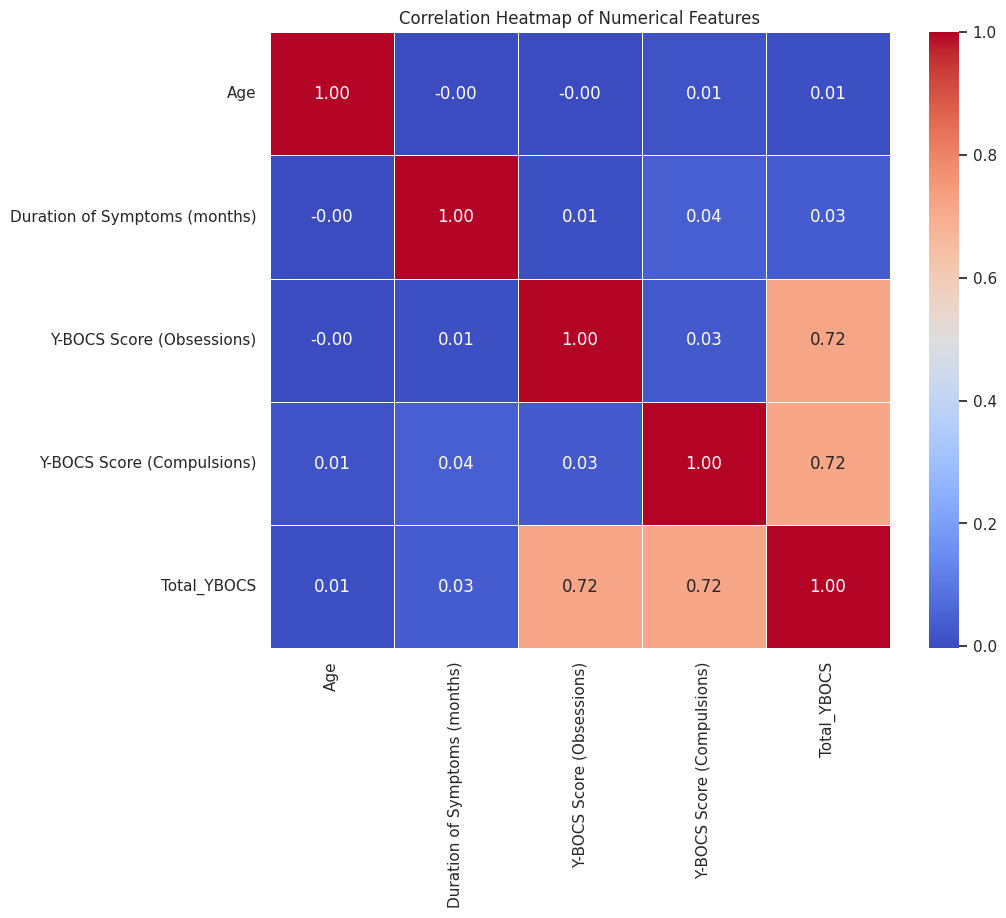

In [67]:
# Select numerical columns for the heatmap, excluding 'Obsession Type' and 'Compulsion Type'
# We also exclude non-numeric columns that might have been introduced like 'Age_Group' and 'Patient ID'
numerical_df = df.select_dtypes(include=np.number).drop(columns=['Patient ID'])

# Calculate the correlation matrix
correlation_matrix = numerical_df.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()
